In [1]:
import os, re, magic, shutil
from glob import glob
import time, datetime
import random
import pandas as pd
import numpy as np
from tqdm import tqdm
import warnings
import joblib
import datetime as dt

import cv2
from PIL import Image
import matplotlib.pyplot as plt
import torch, gc
from torch import nn
from torch.utils.data import Dataset,DataLoader
import torch.nn.functional as F
import torchvision
import torchvision.models as models

#from skimage import io
import sklearn
from sklearn.model_selection import GroupKFold, StratifiedKFold
from sklearn.metrics import roc_auc_score, log_loss, f1_score, confusion_matrix, classification_report
from sklearn import metrics, preprocessing
from scipy.ndimage import zoom

import timm
from timm.data import resolve_data_config
from timm.data.transforms_factory import create_transform
import albumentations as A
import albumentations.pytorch
import wandb


#### Hyper Param Setting

In [2]:
CFG = {
    'fold_num': 5,
    'seed': 42,
    'model': 'resnet152',
    'img_size': 260,
    'epochs': 200,
    'train_bs':64,
    'valid_bs':64,
    'lr': 1e-4, ## learning rate
    'num_workers': 8,
    'verbose_step': 1,
    'patience' : 5,
    'device': 'cuda:0',
    'freezing': False,
    'trainable_layer': 12,
    'model_path': './models'
}

#### wandb init

In [3]:
time_now = dt.datetime.now()
run_id = time_now.strftime("%Y%m%d%H%M%S")
project_name = 'KD_resnet152_19class_' + run_id
user = 'hojunking'
run_name = project_name

In [4]:
path = '../Data/carbon_data/'
dis_names = []
for folder, subfolders, filenames in os.walk(path):
    for img in filenames:
        dis_names.append(folder+'/'+img)
print(len(dis_names))

52210


In [5]:
main_path = '../Data/carbon_data/'
label_list = ["10Kwalk","battery",'box','else','toothcup', 'tumbler','handkerchief',
              'milk', 'paper', 'pet','plug','receipt', 'shopping bag', 'stairs',
             'transportation', 'trash picking', 'green dish','leftover','wrap']

total_train_img_paths = []
total_train_img_labels = []
total_test_img_paths = []
total_test_img_labels = []

for label in label_list: ## 각 레이블 돌기
    print(f'label: {label}')
    img_paths = [] 
    img_labels = []

    # default ratio
    train_ratio = 1500
    test_ratio = 500

    dir_path = main_path + label ## 레이블 폴더 경로
    count = 0
    for folder, subfolders, filenames in os.walk(dir_path): ## 폴더 내 모든 파일 탐색
    
        for img in filenames: ## 각 파일 경로, 레이블 저장
            count +=1
            if count > train_ratio + test_ratio + 10000:
                break
            
            img_paths.append(folder+'/'+img)
            img_labels.append(label)
        
   # random.shuffle(img_paths)
    print(f'img_paths len : {len(img_paths)}\n')

    if label == 'else': ## 10walking 데이터 비율 설정하기 (데이터수: 2494)
        train_ratio = 3000
        test_ratio = 785
    elif label == 'green dish': 
        train_ratio = 1300
        test_ratio = 382
    elif label == 'leftover': 
        train_ratio = 1600
        test_ratio = 378
    elif label == 'wrap': 
        train_ratio = 1200
        test_ratio = 489
    elif label == 'handkerchief':
        train_ratio = 2000
        test_ratio = 433     
    elif label == 'milk':
        train_ratio = 2000
        test_ratio = 375
    elif label == 'paper':
        train_ratio = 1300
        test_ratio = 365
    elif label == 'pet':
        train_ratio = 2000
        test_ratio = 404
    elif label == 'plug':
        train_ratio = 2350
        test_ratio = 581
    elif label == 'receipt':
        train_ratio = 600
        test_ratio = 243 
    elif label == 'shopping bag':
        train_ratio = 1300
        test_ratio = 413
    elif label == 'stairs':
        train_ratio = 3250
        test_ratio = 811
    elif label == 'toothcup':
        train_ratio = 2250
        test_ratio = 557
    elif label == 'tumbler':
        train_ratio = 2676
        test_ratio = 669
    elif label == 'transportation':
        train_ratio = 1800
        test_ratio = 435
    elif label == 'trash picking':
        train_ratio = 1302
        test_ratio = 326
    elif label == '10Kwalk':
        train_ratio = 1556
        test_ratio = 400
    elif label == 'battery':
        train_ratio = 2305
        test_ratio = 500
    elif label == 'box':
        train_ratio = 1600
        test_ratio = 388
        
    total_train_img_paths.extend(img_paths[:train_ratio])
    total_train_img_labels.extend(img_labels[:train_ratio])

    total_test_img_paths.extend(img_paths[-test_ratio:])
    total_test_img_labels.extend(img_labels[-test_ratio:])

print('Train_Images: ',len(total_train_img_paths))
print("Train_Images_labels:", len(total_train_img_labels))
print('Test_Images: ',len(total_test_img_paths))
print("Test_Images_labels:", len(total_test_img_labels))
print("All data",len(total_train_img_paths) + len(total_test_img_paths))

label: 10Kwalk
img_paths len : 1956

label: battery
img_paths len : 2805

label: box
img_paths len : 1988

label: else
img_paths len : 3785

label: toothcup
img_paths len : 2807

label: tumbler
img_paths len : 3345

label: handkerchief
img_paths len : 2433

label: milk
img_paths len : 2375

label: paper
img_paths len : 1665

label: pet
img_paths len : 2404

label: plug
img_paths len : 2931

label: receipt
img_paths len : 843

label: shopping bag
img_paths len : 1713

label: stairs
img_paths len : 4061

label: transportation
img_paths len : 2236

label: trash picking
img_paths len : 1628

label: green dish
img_paths len : 1682

label: leftover
img_paths len : 1978

label: wrap
img_paths len : 1689

Train_Images:  35389
Train_Images_labels: 35389
Test_Images:  8934
Test_Images_labels: 8934
All data 44323


In [24]:
## Pandas 데이터프레임 만들기
trn_df = pd.DataFrame(total_train_img_paths, columns=['image_id'])
trn_df['dir'] = trn_df['image_id'].apply(lambda x: os.path.dirname(x))
trn_df['image_id'] = trn_df['image_id'].apply(lambda x: os.path.basename(x))
trn_df['label'] = total_train_img_labels
train = trn_df
train

,image_id,dir,label
0,10Kwalk_468.jpg,../Data/carbon_data/10Kwalk,10Kwalk
1,10Kwalk_1557.jpg,../Data/carbon_data/10Kwalk,10Kwalk
2,10Kwalk_724.jpg,../Data/carbon_data/10Kwalk,10Kwalk
3,10Kwalk_1303.jpg,../Data/carbon_data/10Kwalk,10Kwalk
4,10Kwalk_1897.jpg,../Data/carbon_data/10Kwalk,10Kwalk
...,...,...,...
35384,wrap_863.jpg,../Data/carbon_data/wrap,wrap
35385,wrap_78.jpg,../Data/carbon_data/wrap,wrap
35386,wrap_1271.jpg,../Data/carbon_data/wrap,wrap
35387,wrap_1578.jpg,../Data/carbon_data/wrap,wrap


In [25]:
# Label Encoding
le = preprocessing.LabelEncoder()
train['label'] = le.fit_transform(train['label'].values)

In [8]:
train

,image_id,dir,label
0,10Kwalk_468.jpg,../Data/carbon_data/10Kwalk,0
1,10Kwalk_1557.jpg,../Data/carbon_data/10Kwalk,0
2,10Kwalk_724.jpg,../Data/carbon_data/10Kwalk,0
3,10Kwalk_1303.jpg,../Data/carbon_data/10Kwalk,0
4,10Kwalk_1897.jpg,../Data/carbon_data/10Kwalk,0
...,...,...,...
35384,wrap_863.jpg,../Data/carbon_data/wrap,18
35385,wrap_78.jpg,../Data/carbon_data/wrap,18
35386,wrap_1271.jpg,../Data/carbon_data/wrap,18
35387,wrap_1578.jpg,../Data/carbon_data/wrap,18


In [9]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

In [10]:
def get_img(path, sub_path=None):
    try:
        im_bgr = cv2.imread(path)
        im_rgb = im_bgr[:, :, ::-1]
        past_path = path
    except: ## 이미지 에러 발생 시 백지로 대체
        im_bgr = cv2.imread('../Data/carbon_reduction/temp_img.jpg')
        im_rgb = im_bgr[:, :, ::-1]
    return im_rgb

In [11]:
transform_train = A.Compose(
    [
        A.RandomResizedCrop(p=1, height=CFG['img_size'] ,width=CFG['img_size'], scale=(0.65, 0.75),ratio=(0.90, 1.10)),
        A.SafeRotate(p=0.5, limit=(-20, 20), interpolation=2, border_mode=0, value=(0, 0, 0), mask_value=None),
        A.HorizontalFlip(p=0.5),
        A.ColorJitter(always_apply=True, p=0.5, contrast=0.2, saturation=0.3, hue=0.2),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0, always_apply=False, p=1.0),
        A.pytorch.transforms.ToTensorV2()
        ])

transform_train_cap = A.Compose(
    [
        A.RandomResizedCrop(p=1, height=CFG['img_size'] ,width=CFG['img_size'], scale=(0.65, 0.85),ratio=(0.90, 1.10)),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0, always_apply=False, p=1.0),
        A.pytorch.transforms.ToTensorV2()
        ])

transform_test = A.Compose(
    [
        A.Resize(height = CFG['img_size'], width = CFG['img_size']),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0, always_apply=False, p=1.0),
        A.pytorch.transforms.ToTensorV2()
        ])

In [12]:
class ColonDataset(Dataset):
    def __init__(self, df, data_root, transform=None, transform2=None, output_label=True):
        super().__init__()
        self.df = df.reset_index(drop=True).copy()
        self.transform = transform
        self.transform2 = transform2
        self.data_root = data_root
        self.output_label = output_label
        
        if output_label == True:
            self.labels = self.df['label'].values
        
        if transform2 == True:
            self.cap_image = le.fit_transform(['10Kwalk', 'battery','receipt'])
        
    def __len__(self):
        return self.df.shape[0]
    
    def __getitem__(self, index: int):
        # GET labels
        if self.output_label:
            target = self.labels[index]
        # GET IMAGES
        path = "{}/{}".format(self.data_root[index], self.df.iloc[index]['image_id'])
        img  = get_img(path)
        
        # TRANSFORM1, TRANSFORM2 PROCESS
        if self.transform2 :
            if target in self.cap_image and self.transform2:
                transformed = self.transform2(image=img)
            else:
                transformed = self.transform(image=img)
        elif self.transform:
            transformed = self.transform(image=img)
        img = transformed['image']
                
        if self.output_label == True:
            return img, target
        else:
            return img

In [13]:
# LOAD PRE-TRAINED MODEL
class Teacher(nn.Module):
    def __init__(self, model_arch, num_classes= 2,pretrained=True):
        super(Teacher, self).__init__()
        self.backbone = models.resnet152(pretrained=pretrained) ## 모델 선언 여기 models.##(pretrained =pretrained)
        self.backbone.fc = nn.Linear(self.backbone.fc.in_features, num_classes)
        
    def forward(self, x):
        x = self.backbone(x)
        return x

In [14]:
# class ForcepImgClassifier(nn.Module):
#     def __init__(self, model_arch, n_class=2, pretrained=False):
#         super().__init__()
#         self.model = timm.create_model(model_arch, pretrained=pretrained, num_classes=n_class)
#         # n_features = self.model.classifier.in_features
#         # self.model.classifier = nn.Linear(n_features, n_class)
#     def freezing(self, freeze=False, trainable_layer = 2):
        
#         if freeze:
#             num_layers = len(list(model.parameters()))
#             for i, param in enumerate(model.parameters()):
#                 if i < num_layers - trainable_layer*2:
#                     param.requires_grad = False    
            
#     def forward(self, x):
#         x = self.model(x)
#         return x

In [15]:
def prepare_dataloader(df, trn_idx, val_idx, data_root=train.dir.values):
    
    train_ = df.loc[trn_idx,:].reset_index(drop=True)
    valid_ = df.loc[val_idx,:].reset_index(drop=True)
    train_data_root = data_root[trn_idx]
    valid_data_root = data_root[val_idx]
    
        
    train_ds = ColonDataset(train_,
                            train_data_root,
                            transform=transform_train,
                            transform2=None,
                            output_label=True)
    valid_ds = ColonDataset(valid_,
                            valid_data_root,
                            transform=transform_test,
                            output_label=True)
    # WEIGHTEDRANDOMSAMPLER
    class_counts = train_.label.value_counts(sort=False).to_dict()
    num_samples = sum(class_counts.values())
    print(f'cls_cnts: {len(class_counts)}\nnum_samples:{num_samples}')
    
    # weight 제작, 전체 학습 데이터 수를 해당 클래스의 데이터 수로 나누어 줌
    class_weights = {l:round(num_samples/class_counts[l], 2) for l in class_counts.keys()}
    t_labels = train_.label.to_list()
    
    # class 별 weight를 전체 trainset에 대응시켜 sampler에 넣어줌
    weights = [class_weights[t_labels[i]] for i in range(int(num_samples))]


    # weight 제작, 전체 학습 데이터 수를 해당 클래스의 데이터 수로 나누어 줌
    class_weights = {l:round(num_samples/class_counts[l], 2) for l in class_counts.keys()}

    # class 별 weight를 전체 trainset에 대응시켜 sampler에 넣어줌
    weights = [class_weights[t_labels[i]] for i in range(int(num_samples))] 
    sampler = torch.utils.data.WeightedRandomSampler(torch.DoubleTensor(weights), int(num_samples))
    
    train_loader = torch.utils.data.DataLoader(
        train_ds,
        batch_size=CFG['train_bs'],
        pin_memory=True,
        drop_last=False,
        shuffle=True,
        #sampler=sampler, 
        num_workers=CFG['num_workers']
    )
    val_loader = torch.utils.data.DataLoader(
        valid_ds, 
        batch_size=CFG['valid_bs'],
        num_workers=CFG['num_workers'],
        shuffle=False,
        pin_memory=True,
    )
    return train_loader, val_loader

In [16]:
def train_one_epoch(epoch, model, loss_fn, optimizer, train_loader, device, scheduler=None):
    ## Sets the model to training mode
    model.train()
    
    t = time.time()
    running_loss = None
    loss_sum = 0
    image_preds_all = []
    image_targets_all = []
    acc_list = []
    
    pbar = tqdm(enumerate(train_loader), total=len(train_loader))
    for step, (imgs, image_labels) in pbar:
        imgs = imgs.to(device).float()
        image_labels = image_labels.to(device).long()
        optimizer.zero_grad()
        
        with torch.cuda.amp.autocast():
            image_preds = model(imgs)   #output = model(input)

            loss = loss_fn(image_preds, image_labels)
            loss_sum+=loss.detach()
            
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        
            if running_loss is None:
                running_loss = loss.item()
            else:
                running_loss = running_loss * .99 + loss.item() * .01    
        
        
            if ((step + 1) % CFG['verbose_step'] == 0) or ((step + 1) == len(train_loader)):
                description = f'epoch {epoch} loss: {running_loss:.4f}'
                pbar.set_description(description)
        
        image_preds_all += [torch.argmax(image_preds, 1).detach().cpu().numpy()]
        image_targets_all += [image_labels.detach().cpu().numpy()]
        
    if scheduler is not None:
        scheduler.step()
    
    image_preds_all = np.concatenate(image_preds_all)
    image_targets_all = np.concatenate(image_targets_all)
    
    matrix = confusion_matrix(image_targets_all,image_preds_all)
    epoch_f1 = f1_score(image_targets_all, image_preds_all, average='macro')
    
    accuracy = (image_preds_all==image_targets_all).mean()
    trn_loss = loss_sum/len(train_loader)
    
    return image_preds_all, accuracy, trn_loss, matrix, epoch_f1

def valid_one_epoch(epoch, model, loss_fn, val_loader, device, scheduler=None, schd_loss_update=False):
    ## Sets the model to valid mode
    model.eval()

    t = time.time()
    loss_sum = 0
    sample_num = 0
    avg_loss = 0
    image_preds_all = []
    image_targets_all = []
    
    acc_list = []
    
    pbar = tqdm(enumerate(val_loader), total=len(val_loader))
    for step, (imgs, image_labels) in pbar:
        imgs = imgs.to(device).float()
        image_labels = image_labels.to(device).long()
        
        image_preds = model(imgs)   #output = model(input)
        image_preds_all += [torch.argmax(image_preds, 1).detach().cpu().numpy()]
        image_targets_all += [image_labels.detach().cpu().numpy()]
        
        loss = loss_fn(image_preds, image_labels)
        avg_loss += loss.item()
        loss_sum += loss.item()*image_labels.shape[0]
        sample_num += image_labels.shape[0]
        
        description = f'epoch {epoch} loss: {loss_sum/sample_num:.4f}'
        pbar.set_description(description)
    
    image_preds_all = np.concatenate(image_preds_all)
    image_targets_all = np.concatenate(image_targets_all)
    matrix = confusion_matrix(image_targets_all,image_preds_all)
    
    epoch_f1 = f1_score(image_targets_all, image_preds_all, average='macro')
    acc = (image_preds_all==image_targets_all).mean()
    val_loss = avg_loss/len(val_loader)
    
    return image_preds_all, acc, val_loss, matrix, epoch_f1

In [17]:
class EarlyStopping:
    def __init__(self, patience=10, verbose=False, delta=0):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta

    def __call__(self, score):
        print(f' present score: {score}')
        if self.best_score is None:
            self.best_score = score
        elif score <= self.best_score + self.delta:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            print(f'Best F1 score from now: {self.best_score}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.counter = 0
        
        return self.early_stop

In [ ]:
if __name__ == '__main__':
    seed_everything(CFG['seed'])
    
    # WANDB TRACKER INIT
    wandb.init(project=project_name, entity=user)
    wandb.config.update(CFG)
    wandb.run.name = run_name
    wandb.define_metric("Train Accuracy", step_metric="epoch")
    wandb.define_metric("Valid Accuracy", step_metric="epoch")
    wandb.define_metric("Train Loss", step_metric="epoch")
    wandb.define_metric("Valid Loss", step_metric="epoch")
    wandb.define_metric("Train Macro F1 Score", step_metric="epoch")
    wandb.define_metric("Valid Macro F1 Score", step_metric="epoch")
    wandb.define_metric("Train-Valid Accuracy", step_metric="epoch")
    
    model_dir = CFG['model_path'] + '/{}_{}'.format(CFG['model'], run_id)
    train_dir = train.dir.values
    best_fold = 0
    best_f1 =0.0
    print('Model: {}'.format(CFG['model']))
    # MAKE MODEL DIR
    if not os.path.isdir(model_dir):
        os.makedirs(model_dir)
    
    # STRATIFIED K-FOLD DEFINITION
    folds = StratifiedKFold(n_splits=CFG['fold_num'], shuffle=True, random_state=CFG['seed']).split(np.arange(train.shape[0]), train.label.values)
    
    # TEST PROCESS FOLD BREAK
    for fold, (trn_idx, val_idx) in enumerate(folds):
        print(f'Training start with fold: {fold} epoch: {CFG["epochs"]} \n')

        # EARLY STOPPING DEFINITION
        early_stopping = EarlyStopping(patience=CFG["patience"], verbose=True)

        # DATALOADER DEFINITION
        train_loader, val_loader = prepare_dataloader(train, trn_idx, val_idx, data_root=train_dir)

        # MODEL & DEVICE DEFINITION 
        device = torch.device(CFG['device'])
        #model = ForcepImgClassifier(CFG['model'], train.label.nunique(), pretrained=True)
        model =Teacher(CFG['model'], train.label.nunique(), pretrained=True)
        
        # MODEL FREEZING
        #model.freezing(freeze = CFG['freezing'], trainable_layer = CFG['trainable_layer'])
        if CFG['freezing'] ==True:
            for name, param in model.named_parameters():
                if param.requires_grad == True:
                    print(f"{name}: {param.requires_grad}")

        model.to(device)
        # MODEL DATA PARALLEL
        if torch.cuda.device_count() > 1:
            model = nn.DataParallel(model)

        scaler = torch.cuda.amp.GradScaler()   
        optimizer = torch.optim.Adam(model.parameters(), lr=CFG['lr'])
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, gamma=0.5, step_size=5)

        # CRITERION (LOSS FUNCTION)
        loss_tr = nn.CrossEntropyLoss().to(device) #MyCrossEntropyLoss().to(device)
        loss_fn = nn.CrossEntropyLoss().to(device)

        wandb.watch(model, loss_tr, log='all')
        train_acc_list = []
        train_matrix_list = []
        train_f1_list = []
        valid_acc_list = []
        valid_matrix_list = []
        valid_f1_list = []
        

        start = time.time()
        print(f'Fold: {fold}')
        for epoch in range(CFG['epochs']):
            print('Epoch {}/{}'.format(epoch, CFG['epochs'] - 1))

            # TRAINIG
            train_preds_all, train_acc, train_loss, train_matrix, train_f1 = train_one_epoch(epoch, model, loss_tr,
                                                                        optimizer, train_loader, device, scheduler=scheduler)
            wandb.log({'Train Accuracy':train_acc, 'Train Loss' : train_loss, 'Train F1': train_f1, 'epoch' : epoch})

            # VALIDATION
            with torch.no_grad():
                valid_preds_all, valid_acc, valid_loss, valid_matrix, valid_f1= valid_one_epoch(epoch, model, loss_fn,
                                                                        val_loader, device, scheduler=None)
                wandb.log({'Valid Accuracy':valid_acc, 'Valid Loss' : valid_loss, 'Valid F1': valid_f1 ,'epoch' : epoch})
            print(f'Epoch [{epoch}], Train Loss : [{train_loss :.5f}] Val Loss : [{valid_loss :.5f}] Val F1 Score : [{valid_f1:.5f}]')
            
            # SAVE ALL RESULTS
            train_acc_list.append(train_acc)
            train_matrix_list.append(train_matrix)
            train_f1_list.append(train_f1)

            valid_acc_list.append(valid_acc)
            valid_matrix_list.append(valid_matrix)
            valid_f1_list.append(valid_f1)

            # MODEL SAVE (THE BEST MODEL OF ALL OF FOLD PROCESS)
            if valid_f1 > best_f1:
                best_f1 = valid_f1
                best_epoch = epoch
                torch.save(model.state_dict(), (model_dir+'/{}').format(CFG['model']))

            # EARLY STOPPING
            stop = early_stopping(valid_f1)
            if stop:
                print("stop called")   
                break

        end = time.time() - start
        time_ = str(datetime.timedelta(seconds=end)).split(".")[0]
        print("time :", time_)

        # PRINT BEST F1 SCORE MODEL OF FOLD
        best_index = valid_f1_list.index(max(valid_f1_list))
        print(f'fold: {fold}, Best Epoch : {best_index}/ {len(valid_f1_list)}')
        print(f'Best Train Marco F1 : {train_f1_list[best_index]:.5f}')
        print(train_matrix_list[best_index])
        print(f'Best Valid Marco F1 : {valid_f1_list[best_index]:.5f}')
        print(valid_matrix_list[best_index])
        print('-----------------------------------------------------------------------')

        # K-FOLD END
        if valid_f1_list[best_index] > best_fold:
            best_fold = valid_f1_list[best_index]
            top_fold = fold
    print(f'Best Fold F1 score: {best_fold} Top fold : {top_fold}')


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: hojunking. Use `wandb login --relogin` to force relogin


Model: resnet152
Training start with fold: 0 epoch: 200 

cls_cnts: 19
num_samples:28311


/home/hojun/miniconda3/envs/torch/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/hojun/miniconda3/envs/torch/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet152_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet152_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Fold: 0
Epoch 0/199


epoch 0 loss: 0.3420: 100%|███████████████████| 111/111 [02:50<00:00,  1.53s/it]


Epoch [0], Train Loss : [0.50185] Val Loss : [0.34205] Val F1 Score : [0.89181]
 present score: 0.8918130355168598
Epoch 1/199


epoch 1 loss: 0.2764: 100%|███████████████████| 111/111 [02:46<00:00,  1.50s/it]


Epoch [1], Train Loss : [0.27117] Val Loss : [0.27724] Val F1 Score : [0.91454]
 present score: 0.914537715485992
Epoch 2/199


epoch 2 loss: 0.2247: 100%|███████████████████| 111/111 [02:46<00:00,  1.50s/it]


Epoch [2], Train Loss : [0.21368] Val Loss : [0.22523] Val F1 Score : [0.93344]
 present score: 0.9334352502779037
Epoch 3/199


epoch 3 loss: 0.2467: 100%|███████████████████| 111/111 [02:45<00:00,  1.49s/it]

Epoch [3], Train Loss : [0.17439] Val Loss : [0.24743] Val F1 Score : [0.92525]
 present score: 0.9252542917046884
EarlyStopping counter: 1 out of 5
Best F1 score from now: 0.9334352502779037
Epoch 4/199



epoch 4 loss: 0.2585: 100%|███████████████████| 111/111 [02:44<00:00,  1.48s/it]

Epoch [4], Train Loss : [0.15218] Val Loss : [0.25894] Val F1 Score : [0.92218]
 present score: 0.9221847912701954
EarlyStopping counter: 2 out of 5
Best F1 score from now: 0.9334352502779037
Epoch 5/199



epoch 5 loss: 0.1819: 100%|███████████████████| 111/111 [02:48<00:00,  1.52s/it]


Epoch [5], Train Loss : [0.08216] Val Loss : [0.18226] Val F1 Score : [0.94874]
 present score: 0.9487443338597275
Epoch 6/199


epoch 6 loss: 0.1855: 100%|███████████████████| 111/111 [02:45<00:00,  1.49s/it]

Epoch [6], Train Loss : [0.06003] Val Loss : [0.18592] Val F1 Score : [0.94581]
 present score: 0.945813441163575
EarlyStopping counter: 1 out of 5
Best F1 score from now: 0.9487443338597275
Epoch 7/199



epoch 7 loss: 0.2052: 100%|███████████████████| 111/111 [02:45<00:00,  1.49s/it]

Epoch [7], Train Loss : [0.05312] Val Loss : [0.20564] Val F1 Score : [0.94114]
 present score: 0.9411399314766546
EarlyStopping counter: 2 out of 5
Best F1 score from now: 0.9487443338597275
Epoch 8/199



epoch 8 loss: 0.0449:  28%|█████▎             | 123/443 [02:46<10:18,  1.93s/it]

In [18]:
## Pandas Test 데이터프레임 만들기
tst_df = pd.DataFrame(total_test_img_paths, columns=['image_id'])
tst_df['dir'] = tst_df['image_id'].apply(lambda x: os.path.dirname(x))
tst_df['image_id'] = tst_df['image_id'].apply(lambda x: os.path.basename(x))
tst_df['label'] = total_test_img_labels
test = tst_df
test

,image_id,dir,label
0,10Kwalk_1455.jpg,../Data/carbon_data/10Kwalk,10Kwalk
1,10Kwalk_898.jpg,../Data/carbon_data/10Kwalk,10Kwalk
2,10Kwalk_1607.jpg,../Data/carbon_data/10Kwalk,10Kwalk
3,10Kwalk_342.jpg,../Data/carbon_data/10Kwalk,10Kwalk
4,10Kwalk_737.jpg,../Data/carbon_data/10Kwalk,10Kwalk
...,...,...,...
8929,wrap_441.jpg,../Data/carbon_data/wrap,wrap
8930,wrap_307.jpg,../Data/carbon_data/wrap,wrap
8931,wrap_1273.jpg,../Data/carbon_data/wrap,wrap
8932,wrap_1137.jpg,../Data/carbon_data/wrap,wrap


In [19]:
test['label'] = le.fit_transform(test['label'].values)
test

,image_id,dir,label
0,10Kwalk_1455.jpg,../Data/carbon_data/10Kwalk,0
1,10Kwalk_898.jpg,../Data/carbon_data/10Kwalk,0
2,10Kwalk_1607.jpg,../Data/carbon_data/10Kwalk,0
3,10Kwalk_342.jpg,../Data/carbon_data/10Kwalk,0
4,10Kwalk_737.jpg,../Data/carbon_data/10Kwalk,0
...,...,...,...
8929,wrap_441.jpg,../Data/carbon_data/wrap,18
8930,wrap_307.jpg,../Data/carbon_data/wrap,18
8931,wrap_1273.jpg,../Data/carbon_data/wrap,18
8932,wrap_1137.jpg,../Data/carbon_data/wrap,18


In [20]:
########################## inference #############################
def inference(model, data_loader, device):
    model.eval()
    image_preds_all = []
    
    pbar = tqdm(enumerate(data_loader), total=len(data_loader))
    for step, (imgs) in pbar:
        imgs = imgs.to(device).float()

        image_preds = model(imgs)   #output = model(input)
        image_preds_all += [torch.softmax(image_preds, 1).detach().cpu().numpy()]
    
    image_preds_all = np.concatenate(image_preds_all, axis=0)
    return image_preds_all

In [21]:
model = Teacher(CFG['model'], test.label.nunique(), pretrained=True)
load_model = CFG['model_path'] + '/resnet152_20230430130050/' + CFG['model']
test_dir = test.dir.values

tst_ds = ColonDataset(test, test_dir, transform=transform_test, output_label=False)
tst_loader = torch.utils.data.DataLoader(
    tst_ds, 
    batch_size=CFG['train_bs'],
    num_workers=CFG['num_workers'],
    shuffle=False,
    pin_memory=True
)
device = torch.device(CFG['device'])
if torch.cuda.device_count() > 1:
        model = nn.DataParallel(model)
model.to(device)

################## get inference #####################
predictions = []
model.load_state_dict(torch.load(load_model))
with torch.no_grad():
    predictions += [inference(model, tst_loader, device)]


#tst_preds = inference_one_epoch(model, tst_loader, device)
predictions = np.mean(predictions, axis=0) 
test['pred'] = np.argmax(predictions, axis=1)
#test['confidence score'] =np.max(predictions, axis=1)

/home/hojun/miniconda3/envs/torch/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/hojun/miniconda3/envs/torch/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet152_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet152_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
100%|█████████████████████████████████████████| 140/140 [02:46<00:00,  1.19s/it]


In [22]:
test

,image_id,dir,label,pred
0,10Kwalk_1455.jpg,../Data/carbon_data/10Kwalk,0,0
1,10Kwalk_898.jpg,../Data/carbon_data/10Kwalk,0,0
2,10Kwalk_1607.jpg,../Data/carbon_data/10Kwalk,0,0
3,10Kwalk_342.jpg,../Data/carbon_data/10Kwalk,0,0
4,10Kwalk_737.jpg,../Data/carbon_data/10Kwalk,0,0
...,...,...,...,...
8929,wrap_441.jpg,../Data/carbon_data/wrap,18,18
8930,wrap_307.jpg,../Data/carbon_data/wrap,18,18
8931,wrap_1273.jpg,../Data/carbon_data/wrap,18,18
8932,wrap_1137.jpg,../Data/carbon_data/wrap,18,18


In [26]:
test['label'] = le.inverse_transform(test['label'].values)
test['pred'] = le.inverse_transform(test['pred'].values)
test

,image_id,dir,label,pred
0,10Kwalk_1455.jpg,../Data/carbon_data/10Kwalk,10Kwalk,10Kwalk
1,10Kwalk_898.jpg,../Data/carbon_data/10Kwalk,10Kwalk,10Kwalk
2,10Kwalk_1607.jpg,../Data/carbon_data/10Kwalk,10Kwalk,10Kwalk
3,10Kwalk_342.jpg,../Data/carbon_data/10Kwalk,10Kwalk,10Kwalk
4,10Kwalk_737.jpg,../Data/carbon_data/10Kwalk,10Kwalk,10Kwalk
...,...,...,...,...
8929,wrap_441.jpg,../Data/carbon_data/wrap,wrap,wrap
8930,wrap_307.jpg,../Data/carbon_data/wrap,wrap,wrap
8931,wrap_1273.jpg,../Data/carbon_data/wrap,wrap,wrap
8932,wrap_1137.jpg,../Data/carbon_data/wrap,wrap,wrap


accuracy: 0.9250
f1_score: 0.9251


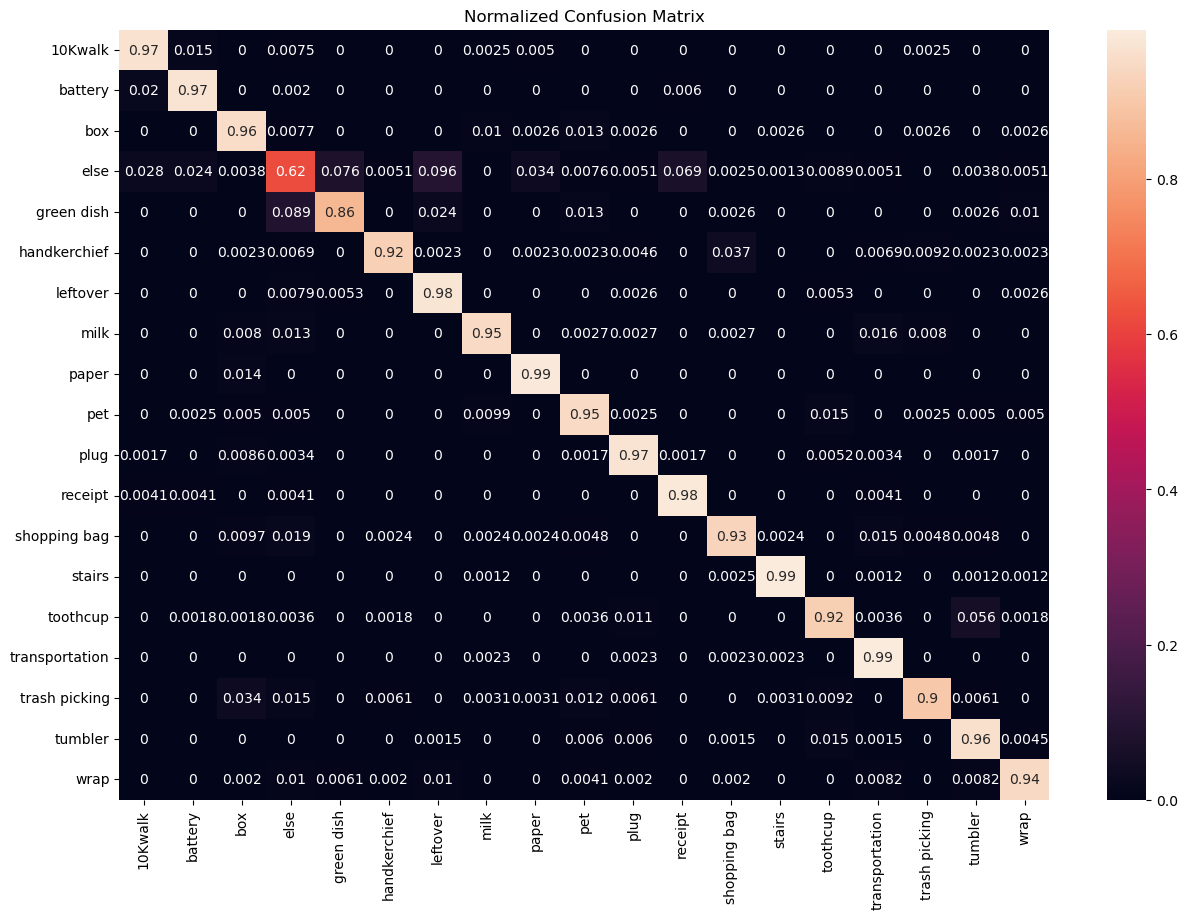

In [27]:
import seaborn as sns

test_acc = np.sum(test.label == test.pred) / len(test)
test_matrix = confusion_matrix(test['label'], test['pred'])
epoch_f1 = f1_score(test['label'], test['pred'], average='macro')
print(f'accuracy: {test_acc:.4f}')
print(f'f1_score: {epoch_f1:.4f}')

test_matrix = confusion_matrix(test['label'], test['pred'], normalize='true')
#test_matrix = confusion_matrix(test['label'], test['pred'])

plt.figure(figsize = (15,10))
sns.heatmap(test_matrix, 
            annot=True, 
            xticklabels = sorted(set(test['label'])), 
            yticklabels = sorted(set(test['label'])),
            )
plt.title('Normalized Confusion Matrix')
plt.show()

#print(f'confusion_matrix \n-------------------------\n {test_matrix}')

In [23]:
test.to_csv('test_result/incep_res_0403.csv', index=False)